# Recommender system for Twitch
## Which Twitch streamers should *YOU* watch?

In [136]:
# data processing & visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# computation
import numpy as np
import scipy.sparse as sparse
from sklearn.metrics.pairwise import cosine_similarity

# ------- modeling --------
# Implicit: https://github.com/benfred/implicit
# Note: I pulled changes from PR #429 which makes corrections to ranking_metrics_at_k
import implicit
from implicit.evaluation import train_test_split
from implicit.evaluation import ranking_metrics_at_k

# LightFM: https://github.com/lyst/lightfm
# Note: I implemented average_precision_at_k
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k, average_precision_at_k
# -------------------------

# miscellaneous utilities
from tqdm import tqdm
from collections import Counter
import pickle

# Preparing data for the Implicit package

Implicit works with sparse matrices, we need to convert our dataframe to a sparse matrix of dimension $(n_\text{users}, n_\text{items})$.

In [95]:
# load preprocessed user-item pairs dataframe
df = pd.read_csv("data/user_follows-2.csv")

# lookup ID corresponding to streamer name or vice versa -- this will be helpful for examining individual recommendations
encode_streamer = {x:y for x,y in zip(df["streamer_name"], df["streamer_name"].astype("category").cat.codes)}
decode_streamer = {y:x for x,y in zip(df["streamer_name"], df["streamer_name"].astype("category").cat.codes)}

# user_ID is already an integer, but we need to convert it to the range [0,n_users). We can do this by converting to categorical
# and then using an ordinal encoder (cat.codes). streamer_name can be dealt with in the same way.
df["user_ID"] = df["user_ID"].astype("category").cat.codes
df["streamer_name"] = df["streamer_name"].astype("category").cat.codes

# We'll use the 3rd column as the value in the interaction matrix
# By setting it to 1 we're saying the values in the interaction matrix are in {0,1}
# It might be worth weighting this value by the time followed at (older/newer follows more predictive of "liking" the streamer?)
df["followed_at"] = 1

# rename columns
df.rename(columns={"streamer_name":"streamer_ID", "followed_at":"weight"}, inplace=True)

# convert dataframe to sparse matrix
user_items = sparse.csr_matrix( (df["weight"], (df['user_ID'], df['streamer_ID'])) ) # format for fitting is (item,user)

n_users, n_items = user_items.shape

## Train-test split & validation
We split our data into training (80%), validation (10%), and testing (10%). Part of our reason for this ratio (as opposed to 60%, 20%, 20%) is to avoid having items with few users or users with few items within the training set. Future work should investigate the impact of this choice, and would ideally also use cross-validation; however, due to time considerations we will not.

We will use our validation set to tune hyperparameters and choose the best model over several candidates, and then report the performance of the best model at the end.

In [96]:
r = np.random.RandomState(42)
tp = 0.9 # train percentage
train_user_items, test_user_items = train_test_split(user_items, train_percentage=tp, random_state=r)
train_user_items, val_user_items = train_test_split(train_user_items, train_percentage=2-1/tp, random_state=r)
train_user_items.shape, val_user_items.shape, test_user_items.shape

((10985, 1904), (10985, 1904), (10985, 1904))

We check the training set below to make sure every user has at least one item and every item has at least one user. Fortunately everything checks out; however, in some cases we might've needed to add back in user-item pairs.

In [97]:
train_user_sums = train_user_items.sum(axis=1)
train_item_sums = train_user_items.sum(axis=0)

print("Number of users with at least 1 item:", (train_user_sums > 0).sum(), "/", n_users )
print("Number of items with at least 1 user:", (train_item_sums > 0).sum(), "/", n_items ) 

Number of users with at least 1 item: 10985 / 10985
Number of items with at least 1 user: 1904 / 1904


How many total (positive) interactions are in each dataset? What is the average number of interactions per user and per item?

In [98]:
print("Train | val | test")
print("Total interactions:", train_user_items.sum(), "|", val_user_items.sum(), "|", test_user_items.sum())
print("Avg interactions/user:", train_user_items.sum()/n_users, "|", val_user_items.sum()/n_users, "|", test_user_items.sum()/n_users)
print("Avg interactions/item:", train_user_items.sum()/n_items, "|", val_user_items.sum()/n_items, "|", test_user_items.sum()/n_items)

Train | val | test
Total interactions: 222131 | 27450 | 27717
Avg interactions/user: 20.22130177514793 | 2.4988620846609013 | 2.523167956304051
Avg interactions/item: 116.6654411764706 | 14.417016806722689 | 14.557247899159664


Below we plot distributions of interactions/user and interactions/item in the training and validation sets (the test set is not noticeably different, so we omit it).

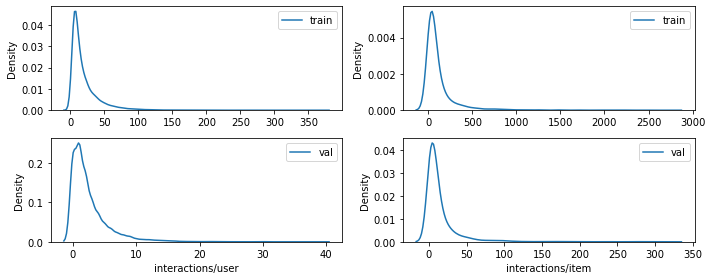

In [99]:
def fmt_sums(m, axis):
    return np.squeeze(np.asarray(m.sum(axis=axis)))

t0 = pd.DataFrame({"train":fmt_sums(train_user_items,1)})
v0 = pd.DataFrame({"val":fmt_sums(val_user_items,1)})
t1 = pd.DataFrame({"train":fmt_sums(train_user_items,0)})
v1 = pd.DataFrame({"val":fmt_sums(val_user_items,0)})

fig, ax = plt.subplots(2,2, figsize=(10,4))
ax = ax.flatten()
for i,data in enumerate([t0,t1,v0,v1]):
    plt.sca(ax[i])
    sns.kdeplot(data=data)
    if i == 2:
        plt.xlabel("interactions/user")
    if i == 3:
        plt.xlabel("interactions/item")
plt.tight_layout()
plt.show()

**Considerations:** In the validation & test set each user has on average only 2.5 items which they've interacted with. This has implications for using "@K" metrics to evaluate our model. Say we choose $K=10$; we can only suggest 2-3 relevant items, which means the best precision at cutoff K we can get is 0.2-0.3. Some data scientists suggest a variation of precision @ K which accounts for this, and ends up having a maximum value of 1 -- however, we'll just leave it as is.

We can also see that the distributions of interactions are highly skewed right (some items have many users and some users have many items).

# Baseline: popularity model
Before we fit our model, let's check out a baseline. We use `train_item_sums` to count the number of users per item and sort by popularity to get `ranks` below. In testing, for each user we remove any of the items that they had at training and rank the remaining by popularity. We compute P@K, R@K, and mAP@K below (this runs slower than evaluating the complex models because my implementation is NOT in Cython).

In [100]:
def get_baseline_eval(train_user_items, test_user_items, K_list=[5,10]):
    train_item_sums = train_user_items.sum(axis=0)
    ranks = sorted([(i,x) for i,x in enumerate(np.squeeze(np.asarray(train_item_sums)))], key=lambda x: -x[1])
    
    data = []
    for K in K_list:
        relevant = 0
        precision_div = 0
        recall_div = 0
        mean_ap = 0

        pbar = tqdm(range(n_users))
        for user_id in pbar:
            test_likes = test_user_items[user_id,:].nonzero()[1]

            # if no test likes, skip user
            if len(test_likes) == 0:
                pbar.update(1)
                continue

            # avoid recommending items already liked in training set
            train_likes = train_user_items[user_id,:].nonzero()[1]
            recs = [i for i,x in ranks if i not in train_likes]
            recs = recs[:min(K, len(recs))] # top K

            # calculate user's precision & recall (for test set)
            ap = 0
            hit = 0
            for i in range(K):
                if recs[i] in test_likes:
                    relevant += 1
                    hit += 1
                    ap += hit/(i+1)

            mean_ap += ap/K
            precision_div += K
            recall_div += len(test_likes)

            pbar.update(1)
        
        pr = relevant/precision_div
        re = relevant/recall_div
        mean_ap = mean_ap/n_users
        data.append( [pr, re, mean_ap] )
        
    df = pd.DataFrame(data=data).T
    df.columns = ["K=%i" % K for K in K_list]
    df.index = ["P@K", "R@K", "MAP@K"]
    return df
        
evals = get_baseline_eval(train_user_items, val_user_items, K_list=[5,10])
evals

100%|███████████████████████████████████████████████████████████████████████████| 10985/10985 [00:47<00:00, 229.98it/s]


,K=5,K=10
P@K,0.049374,0.037013
R@K,0.075446,0.113115
MAP@K,0.021525,0.012661


Our baseline model gives `P@K` of 3.7% for $K=10$ indicating of the top 10 items recommended only 3.7% were actually relevant. The `R@K` for $K=10$ indicates that 11.3% of relevant items were recommended within the top 10. This is not a bad baseline, but we'll soon see that we can do better. 

# Fit Implicit model

The Implicit package offers an efficient way for doing collaborative filtering with implicit feedback. Because models for implicit feedback optimize over all user-item pairs (rather than just observer pairs), an efficient algorithm is needed. The algorithm, Alternating Least Squares, alternates between optimizing user and item latent factors. The algorithm solves the optimization problem
$$\min_{x_*, y_*} \sum_{u,i} c_{ui} (p_{ui}-x_u^T y_i)^2 + \lambda \left(\sum_u \lVert x_u\rVert^2 + \sum_i \lVert y_i\rVert^2\right).$$
Here $\{x_u\}_{u=1}^m$ are the latent user factors and $\{y_i\}_{i=1}^n$ are the latent item factors which we are trying to optimize for, $c_{ui}$ is a confidence score in each interaction $r_{ui}$, $p_{ui}$ is a binarized version of $r_{ui}$ (1 if $r_{ui} > 0$, else 0), and $\lambda$ is a regularization factor.

For us we just set $c_{ui}=1$ since we do not have any way to judge our confidence in the interactions. In some implicit feedback tasks the modeler may have data on # clicks, # purchases, etc., but we only have binary follow/no-follow interactions. 

In [101]:
# fit model
model = implicit.als.AlternatingLeastSquares(factors=60, regularization=20, iterations=100, random_state=r)
model.fit(train_user_items.T) # format for fitting is item_users

In [104]:
def get_implicit_eval(model, train_user_items, test_user_items, K_list=[5,10]):
    data = []
    for K in K_list:   
        rm = ranking_metrics_at_k(model, train_user_items, test_user_items, K=K, show_progress=False)
        data.append( [rm[x] for x in ["precision_correct", "recall_correct", "map_correct"]] )
    
    df = pd.DataFrame(data=data).T
    df.columns = ["K=%i" % K for K in K_list]
    df.index = ["P@K", "R@K", "MAP@K"]
    return df

evals = get_implicit_eval(model, train_user_items, val_user_items, K_list=[5,10])
evals

,K=5,K=10
P@K,0.129932,0.096317
R@K,0.198543,0.294353
MAP@K,0.084649,0.051034


Looking at $K=10$, from `P@K` we see that of the top 10 items, on average 9.6% are liked by the user. On the other hand, `R@K` tells us that of the user's likes, on average 29.4% were listed in the top 10 items. This is significantly better than the baseline model. We also see that `MAP@K` is higher, indicating that when we do identify relevant recommendations -- this model tends to rank them more highly in the list.

We experimented with several different hyperparameter choices before settling on `factors=60`, `regularization=20`, and `iterations=100`. In general we found that increasing the number of latent factors is beneficial provided that regularization is increased simultaneously.

## Looking at the actual recommendations

### Suggesting similar items

In [105]:
streamer_name = "xQcOW"
[decode_streamer[streamer_id] for streamer_id,score in model.similar_items(itemid=encode_streamer[streamer_name], N=10)]

['xQcOW',
 'dinossindgeil',
 'TommyKayLIVE',
 'MightyTeapot',
 'adeptthebest',
 'MixelPlx',
 'TheJRM_',
 'allkeyshop_tv',
 'Trainwreckstv',
 'pokelawls']

Below we present the math behind this. We compute the cosine similarity between the latent factors for the item of interest $y_\text{xQcOW}$ and all the other items' latent factors $y_i$. Then we rank the items by scores and present the top $K$.

In [106]:
# make recommendations
content_id = encode_streamer[streamer_name] # streamer ID
n_similar = 10

person_vecs = model.user_factors
content_vecs = model.item_factors

content_norms = np.sqrt((content_vecs * content_vecs).sum(axis=1))

scores = content_vecs.dot(content_vecs[content_id]) / content_norms
top_idx = np.argpartition(scores, -n_similar)[-n_similar:]
similar = sorted(zip(top_idx, scores[top_idx] / content_norms[content_id]), key=lambda x: -x[1])

for content in similar:
    idx, score = content
    print(decode_streamer[idx])

xQcOW
dinossindgeil
TommyKayLIVE
MightyTeapot
adeptthebest
MixelPlx
TheJRM_
allkeyshop_tv
Trainwreckstv
pokelawls


### Suggest items to a (unseen) user
Suggesting items to a user $u$ is similar. Our model was designed to minimize the difference between $x_u^T y_i$ and their actual feedback $p_{ui}$, so all that needs to be done is compute $x_u^T y_i$ for all items $i$ and then rank by items. We omit the Python implementation and just use Implicit's `model.recommend()` method.

Normally, to make recommendations to an **unseen** user (provided they are not *new*, i.e. they have interaction data) one would retrain the model. To save time here, at the cost of accuracy, I'm just going to find the user that has the most similar interaction vector to mine and query their recommendations.

In [117]:
# I retrieved my follows from the Twitch API and saved them to `data/my_follows.txt`
with open("data/my_follows.txt", "r") as f:
    my_follows = f.read().split("\n")

# convert streamer names to IDs (if they are in our list of top streamers)
my_follows_ID = [encode_streamer[x] for x in my_follows if x in encode_streamer] 
# generate my interaction vector
my_interactions = np.zeros(content_vecs.shape[0])
for ind in my_follows_ID:
    my_interactions[ind] = 1

# get most similar user in training data...
user_sim_scores = cosine_similarity(my_interactions.reshape(1,-1), train_user_items)
most_sim_user_ID = np.argmax(user_sim_scores)

# display some data
print("Who I follow:")
print(my_follows)
print("\n")
print("Most similar user to me (ID):", most_sim_user_ID)
print("Who they follow:")
most_sim_user_follows = [decode_streamer[i] for i,x in enumerate(train_user_items[most_sim_user_ID,:].toarray()[0]) if x==1]
print(most_sim_user_follows)
print("\n")
print("Number of common follows:", len(set(my_follows).intersection(set(most_sim_user_follows))))
print("Number of uncommon follows:", len(set(my_follows).symmetric_difference(set(most_sim_user_follows))))

Who I follow:
['imls', 'akaNemsko', 'Chess', 'HealthyGamer_GG', 'chess24', 'BotezLive', 'SpectateTyler1', 'GMHikaru', 'HasanAbi', 'Kandyland', 'OvileeMay', 'LCS', 'LEC', 'RATIRL', 'MOONMOON', 'trihex', 'MitchJones', 'SaltyTeemo', 'Maya', 'Mizkif', 'midbeast', 'Macaiyla', 'IWillDominate', 'Trainwreckstv', 'Rush', 'xQcOW', 'TFBlade', 'Jenna', 'Aphromoo', 'AustinShow', 'Faux', 'Stephen_Wolfram', 'UberHaxorNova', 'forsen', 'DrDisrespect', 'aleks', 'sodapoppin', 'pokimane', 'imaqtpie', 'LLStylish', 'erobb221', 'Viper', 'Yassuo', 'Destiny', 'summit1g', 'Greekgodx', 'Faker', 'B0aty', 'Becca', 'sneakylol', 'Reckful', 'loltyler1', 'Ice_Poseidon', 'CowChop', 'Sp00nerism', 'JERICHO', 'hexy', 'Doublelift', 'Rivington', 'GoldGlove', 'PhreakStream', 'LIRIK', 'Nightblue3', 'Trick2g', 'Wingsofdeath', 'TSM_Bjergsen', 'Riot Games']


Most similar user to me (ID): 7367
Who they follow:
['5uppp', 'AustinShow', 'BotezLive', 'Chess', 'Destiny', 'DevinNash', 'Doublelift', 'Elite500', 'GMBenjaminFinegold', 'G

In [119]:
# Recommendations for be based on this user
[(decode_streamer[x],i) for x,i in model.recommend(userid=most_sim_user_ID, user_items=train_user_items, N=50) \
 if x not in my_follows_ID][:10]

[('Gosu', 0.34143364),
 ('boxbox', 0.30302092),
 ('itsHafu', 0.28715616),
 ('tarzaned', 0.27704456),
 ('shroud', 0.26817885),
 ('TwitchRivals', 0.24474329),
 ('Scarra', 0.24288088),
 ('m0xyy', 0.2417853),
 ('ludwig', 0.23346373),
 ('KarasMai', 0.2193809)]

Interesting results, it appears to recommend me a lot of League of Legends streamers (Gosu, boxbox, tarzaned, Scarra, KarasMai) which is one of my main interests.

# LightFM

Factorization Machines (FM) go one step beyond traditional matrix factorization models. They allow the modeler to incoporate user features (i.e. demographic information) and item features (i.e. movie genre) into the model. More details can be found in the paper "[Metadata embeddings for user and item cold-start recommendations](https://arxiv.org/pdf/1507.08439.pdf)."

## Traditional CF-MF in LightFM with WARP loss
Unlike the ALS algorithm, the LightFM library optimizes an explicit likelihood function using stochastic gradient descent (SGD). The library allows for different losses such as 'Weighted Approximate-Rank Pairwise' (WARP) and 'Bayesian Personalized Ranking' (BPR). Supposedly, WARP will lead to better peformance at the top of the rankings (`*@K` metrics) whereas BPR will lead to higher AUC. Since we're only concerned with provides 5-10 recommendations we find that WARP is more appropriate.

In [120]:
model = LightFM(no_components=20, learning_schedule='adagrad', loss='warp', learning_rate=0.1, random_state=r)
model.fit(interactions=train_user_items, epochs=50, num_threads=2, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49


In [121]:
def get_lightfm_eval(model, train_user_items, test_user_items, item_features=None, K_list=[5,10]):
    data = []
    for K in K_list:
        pr = precision_at_k(model, test_interactions=test_user_items, train_interactions=train_user_items, \
                            item_features=item_features, k=K).mean()
        re = recall_at_k(model, test_interactions=test_user_items, train_interactions=train_user_items, \
                         item_features=item_features, k=K).mean()
        mean_ap = average_precision_at_k(model, test_interactions=test_user_items, train_interactions=train_user_items, \
                                         item_features=item_features, k=K).mean()
        data.append( [pr, re, mean_ap] )
        
    df = pd.DataFrame(data=data).T
    df.columns = ["K=%i" % K for K in K_list]
    df.index = ["P@K", "R@K", "MAP@K"]
    return df

evals = get_lightfm_eval(model, train_user_items, val_user_items, item_features=None, K_list=[5,10])
evals

,K=5,K=10
P@K,0.127238,0.097342
R@K,0.226163,0.333418
MAP@K,0.082168,0.050503


We see that this model has improved recall over the model from Implicit, while maintaining similar precision and mean average precision.

In [123]:
# Let's check out my recommendations again
my_recs = model.predict(user_ids=[most_sim_user_ID], item_ids=list(range(n_items)))
my_recs = [(decode_streamer[i],x) for i,x in enumerate(my_recs) if i not in my_follows_ID]
sorted(my_recs, key=lambda x: -x[1])[:10]

[('Voyboy', -1.5568833351135254),
 ('Jankos', -1.7461189031600952),
 ('Sanchovies', -2.0605523586273193),
 ('Gosu', -2.073958396911621),
 ('itsHafu', -2.0775504112243652),
 ('tarzaned', -2.2232468128204346),
 ('Scarra', -2.2937850952148438),
 ('Shiphtur', -2.316772222518921),
 ('KarasMai', -2.3610713481903076),
 ('shroud', -2.363858461380005)]

There are several recommendations in common with the previous model, but also a few new ones such as Sanchovies and Jankos appearing within the top 5.

## Hybrid CB/CF recommender with WARP loss
The goal of this section is to try to improve upon our previous models by incorporating item metadata. That is we aim to develop a hybrid CB/CF recommender. CB methods are known to solve the cold-start problem that CF methods face with users or items that do not have sufficient ratings.

## Preparing item features

In the data collection process we also retrieved data on streamers such as what games they play, stream duration, career metrics, and more. We suspect that game data may be useful for our model. 

To incorporate game data, we first identify the most common $n_\text{games}$ games played by all streamers. We then create a matrix $A$ of dimension $(n_\text{streamers}, n_\text{games})$ to use as our item features. Each entry $a_{ij}$ represents the percentage airtime of game $j$ by streamer $i$. Note we only originally collected data on the top 10 games for each streamer, so each row will contain at most 10 nonzero entries. Furthermore the row sums need not at to unity if the streamer has played more than 10 unique games. 

As suggested by LightFM, we prepend an identity matrix of dimension $(n_\text{streamer}, n_\text{streamers})$ to $A$ so that each item gets its own *unique* feature. The following three blocks build $A$ and store in `item_features`. 

In [124]:
# get list of all games played (includes duplicates)
games = []
for streamer in encode_streamer:
    df = pd.read_csv("data/games/%s.csv" % streamer)
    if len(df) > 0:
        games.extend(df["Game"].values.tolist())

# total games, total unique games
len(games), len(set(games))

(17178, 1378)

In [125]:
# get most common games and initialize matrix A of dimension (n_items, n_features)
n_item_features = 50 # play around with this -- is more or less better? Note: More games = sparser matrix 
c = Counter(games).most_common() # games ranked in order of popularity
most_common_games = [x for x,i in c if x not in ["Unknown", np.nan]][:n_item_features]
most_common_games_lookup = {x:i for i,x in enumerate(most_common_games)}
item_features = np.zeros((n_items, n_item_features))

In [126]:
# fill in matrix A with "percent airtime"
for i,streamer in enumerate(encode_streamer):
    df = pd.read_csv("data/games/%s.csv" % streamer)
    df = df[~df.isna().any(axis=1)]
    if len(df) > 0:
        games_played = df["Game"].values
        pct_airtime = df["Total airtime"].apply(lambda x: x.split("hrs")[1].strip("%")).astype('float').values
        idxs = [most_common_games_lookup[x] for x in games_played if x in most_common_games_lookup]
        for j in range(len(idxs)):
            item_features[i, idxs[j]] += pct_airtime[j]
            
item_features = item_features/100 # scale between 0,1
item_features = np.hstack((np.identity(n_items), item_features)) # append identity matrix (each item gets its own "bias")
item_features = sparse.csr_matrix(item_features) # convert to sparse matrix

### Training the LightFM model with item features

In [127]:
model = LightFM(no_components=40, learning_schedule='adagrad', loss='warp', learning_rate=0.05, item_alpha=0.0005, \
                user_alpha=0.0005, max_sampled=20, random_state=r)

# fit with item features
model.fit(interactions=train_user_items, user_features=None, item_features=item_features, epochs=25, \
          num_threads=2, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24


In [128]:
evals = get_lightfm_eval(model, train_user_items, val_user_items, item_features=item_features, K_list=[5,10])
evals

,K=5,K=10
P@K,0.136155,0.102515
R@K,0.243668,0.352885
MAP@K,0.088600,0.053924


Although slight, we appear to have improved upon the model with no item features (which is actually surprising because many modelers report that including user and item features harmed performance in their use case; see e.g. https://github.com/lyst/lightfm/issues/486). 

Note that there are many hyperparameters to tune here and performance of LightFM appears to be highly sensitive to these choices. A full grid search, or using a more complex hyperparameter optimization routine such as that implemented in [Hyperopt](https://github.com/hyperopt/hyperopt), could see large improvements.

### Final recommendations

In [129]:
my_recs = model.predict(user_ids=[most_sim_user_ID], item_ids=list(range(n_items)), \
                        user_features=None, item_features=item_features)

In [130]:
my_recs = [(decode_streamer[i],x) for i,x in enumerate(my_recs) if i not in my_follows_ID]
sorted(my_recs, key=lambda x: -x[1])[:10]

[('Voyboy', 1.8115627765655518),
 ('Scarra', 1.1126089096069336),
 ('Jankos', 1.0532543659210205),
 ('Gosu', 1.0391225814819336),
 ('shroud', 0.9977701306343079),
 ('Shiphtur', 0.9266618490219116),
 ('itsHafu', 0.8668867945671082),
 ('tarzaned', 0.7602359056472778),
 ('boxbox', 0.754257321357727),
 ('dogdog', 0.7473652362823486)]

# The best model

## Testing performance
Below we report the testing performance of the best model.

In [131]:
evals = get_lightfm_eval(model, train_user_items, test_user_items, item_features=item_features, K_list=[5,10])
evals

,K=5,K=10
P@K,0.136432,0.102253
R@K,0.252878,0.361051
MAP@K,0.088409,0.053496


Not bad! Within the top 5 recommendations we retrieve 25% of relevant items and within the top 10 we retrieve 36%. Of course, with implicit feedback it is hard to judge these metrics and their potential business impact. The proper way would be to conduct an A/B test and measure customer satisfication/churn. For now we'll leave it at that :)

## Saving the best model

In [134]:
pickle.dump(model, open("data/best_model/lfm_with_itemfeats_best.pkl", 'wb'))

Let's also save the streamer:ID encoding `encode_streamer` and necessary data (sparse matrices): `train_user_items` and `item_features`.

In [135]:
pickle.dump(train_user_items, open("data/best_model/train_user_items.pkl", 'wb'))
pickle.dump(item_features, open("data/best_model/item_features.pkl", 'wb'))
pickle.dump(encode_streamer, open("data/best_model/encode_streamer.pkl", 'wb'))